In [1]:
import collections
import pandas as pd
import numpy as np
import re
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Embedding

Using TensorFlow backend.


In [2]:
train_data=pd.read_csv("C:\\Users\\mayan\\Desktop\\kajal SA\\train (3) (1) (3) (2).csv")
test_data=pd.read_csv("C:\\Users\\mayan\\Desktop\\kajal SA\\test (3) (1) (3) (2).csv")
#load from whereever the files are
sample_size=len(train_data)
train_data[:2]

,id,App Version Code,App Version Name,Review Text,Review Title,Star Rating
0,b817b0f0-a2f8-4c9d-a5f6-d3fbf8b1d7e9,NaN,NaN,Very bad wallet balance not use.,NaN,1
1,c7844e8f-56c1-487b-ae3e-df2fdf4c1767,43.0,2.3,Froud app i recharge 199 but not done also sen...,NaN,1


In [3]:
test_data[:2]

,id,App Version Code,App Version Name,Review Text,Review Title
0,bdcb3129-afc1-4608-825f-558fe9c17e2b,78.0,2.37,"Awesome app, all should use it",NaN
1,7518d5c8-5e35-45e2-b29d-cf0996ba9e2f,75.0,2.34,how can i stop notification,NaN


In [4]:
words=[]
sumlength=0
for i in range(sample_size):
    line=str(train_data['Review Text'][i])
    S=re.split(r'(;|,|\.|\s)\s*', line)
    sumlength=sumlength+len(S)
    words=words+S
count=collections.Counter(words)
avgln=sumlength/sample_size
maxlength=int(2*avgln) #restricting max length for memory efficiency
words=['insig','VacantSpace'] #adding labels for ambiguoous words not in dictionary to handle that exception
for i in count.keys():
    if count[i]>3: #removing insignificant words and also ambiguous words. try 3,4 or 5 instead
        words=words+[i]
dim=len(words)
embed_dim=15*int(dim**(1/2))
table={words[i]:i for i in range(dim)}

In [5]:
def sentence2sequence(line):
    S=re.split(r'(;|,|\.|\s)\s*', str(line))
    lens=len(S)
    seq=[]
    for i in range(maxlength):
        if i<lens:
            if S[i] in table:
                seq=seq+[table[S[i]]]
            else:
                seq=seq+[table['insig']]
        else:
            seq=seq+[table['VacantSpace']]
    return np.array(seq)
#play with these parameters for more efficient(maybe) solving
nepochs=50
nlstm=30
ndense=10

In [6]:
X_train=np.array([sentence2sequence(i) for i in list(train_data['Review Text'])])
Y_train=np.array([i for i in list(train_data['Star Rating'])])
fivep=int(0.05*len(X_train))
#validating accuracy on some training data itself
Xtest=X_train[-fivep:]
Ytest=Y_train[-fivep:]

In [7]:
model=Sequential()
model.add(Embedding(dim,embed_dim))
model.add(LSTM((30),batch_input_shape=(None,maxlength,embed_dim),return_sequences=False,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss="mean_absolute_error",optimizer="adam",metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 615)         1048575   
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                77520     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,126,416
Trainable params: 1,126,416
Non-trainable params: 0
_________________________________________________________________


In [8]:
history=model.fit(X_train,Y_train,epochs=nepochs,validation_data=(Xtest,Ytest))

Train on 5693 samples, validate on 284 samples
Epoch 1/50
5693/5693 [==============================] - 10s 2ms/step - loss: 1.5828 - acc: 0.3819 - val_loss: 1.1190 - val_acc: 0.5563
Epoch 2/50
5693/5693 [==============================] - 10s 2ms/step - loss: 0.8496 - acc: 0.6267 - val_loss: 0.5355 - val_acc: 0.7254
Epoch 3/50
5693/5693 [==============================] - 9s 2ms/step - loss: 0.5189 - acc: 0.7493 - val_loss: 0.4473 - val_acc: 0.7711
Epoch 4/50
5693/5693 [==============================] - 9s 2ms/step - loss: 0.4525 - acc: 0.7688 - val_loss: 0.3923 - val_acc: 0.7887
Epoch 5/50
5693/5693 [==============================] - 11s 2ms/step - loss: 0.4135 - acc: 0.7811 - val_loss: 0.4045 - val_acc: 0.8063
Epoch 6/50
5693/5693 [==============================] - 12s 2ms/step - loss: 0.4007 - acc: 0.7901 - val_loss: 0.3813 - val_acc: 0.8099
Epoch 7/50
5693/5693 [==============================] - 12s 2ms/step - loss: 0.3779 - acc: 0.7917 - val_loss: 0.3456 - val_acc: 0.8028
Epoch 8/50

In [9]:
prediction_args=np.array([sentence2sequence(i) for i in list(test_data['Review Text'])])
predictions=model.predict(prediction_args)
predictions=[round(i[0]) for i in predictions]

In [10]:
prediction_table=test_data
prediction_table['Star rating']=predictions
prediction_table.to_csv('prediction_table.csv')

# Exploratory data analysis

In [32]:
import matplotlib.pyplot as plt

words2=[]
lengths2=[]
for i in range(len(test_data)):
    line=str(test_data['Review Text'][i])
    S=re.split(r'(;|,|\.|\s)\s*', line)
    lengths2=lengths2+[len(S)]
    words2=words2+S
count2=collections.Counter(words2)
lenfreq2=collections.Counter(lengths2)
x2=sorted(lenfreq2.keys())
y2=[lenfreq2[i] for i in x2]
fcount2=collections.Counter(count2.values())
xf2=sorted(fcount2.keys())
xf2=xf2[:int(len(xf2)/3)]
yf2=[fcount2[i] for i in xf2]

lengths=[]
for i in range(sample_size):
    line=str(train_data['Review Text'][i])
    lengths=lengths+[len(re.split(r'(;|,|\.|\s)\s*', line))]
lenfreq=collections.Counter(lengths)
x=sorted(lenfreq.keys())
y=[lenfreq[i] for i in x]
fcount=collections.Counter(count.values())
xf=sorted(fcount.keys())
xf=xf[:int(len(xf)/3)]
yf=[fcount[i] for i in xf]

We look at the nature of length of comments and also the word frequency. We dont need di-gram, n-gram word frequencies for our
model as we are using an embedding layer. also we are allowed to consider things like '..' or just blank spaces as words, since
there effect is determined by the LSTM weights(also modern day typing is weird)

First we plot the frequency graph of length of reviews in training data

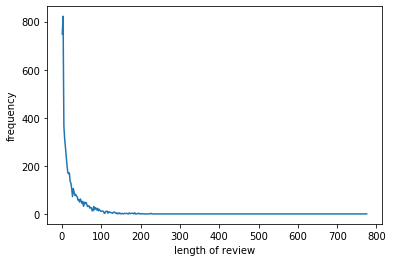

In [33]:
plt.plot(x,y)
plt.xlabel('length of review')
plt.ylabel('frequency')
plt.show()

Now we have the same(frequency graph of length of reviews) for the test prediction data.

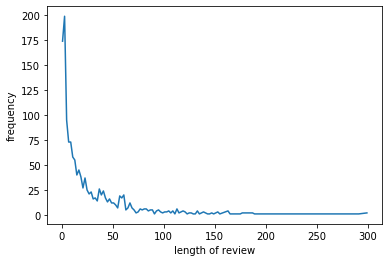

In [34]:
plt.plot(x2,y2)
plt.xlabel('length of review')
plt.ylabel('frequency')
plt.show()

Next we look at 10 most frequent words in training data. First 3 are ambiguous  strings {'.',' ',''} in the embedding which we ommit here

<BarContainer object of 10 artists>

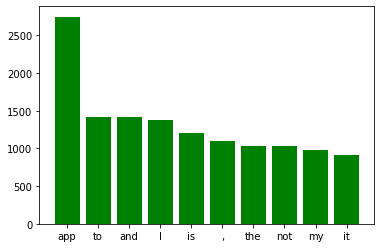

In [35]:
a1_sorted_keys = sorted(count, key=count.get, reverse=True)[3:13]
plt.bar(a1_sorted_keys, [count[i] for i in a1_sorted_keys], color='g')

10 most frequent words in testing data. First 3 are ambiguous  strings {'.',' ',''} in the embedding which we ommit here

<BarContainer object of 10 artists>

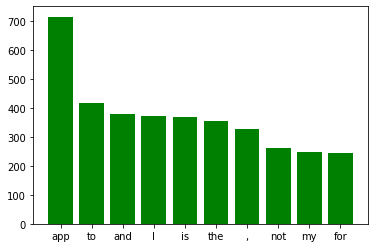

In [36]:
a1_sorted_keys2 = sorted(count2, key=count2.get, reverse=True)[3:13]
plt.bar(a1_sorted_keys2, [count2[i] for i in a1_sorted_keys2], color='g')

Next we see how many words are used frequently and how many are seldom used, i.e. we look at the frequency of frequency of words

first in training data

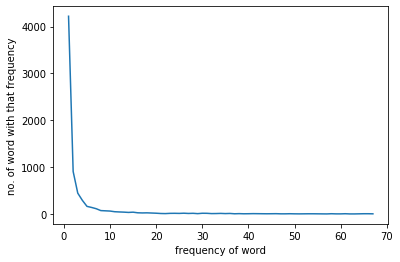

In [37]:
plt.plot(xf,yf)
plt.xlabel('frequency of word')
plt.ylabel('no. of word with that frequency')
plt.show()

Now the same for test prediction data

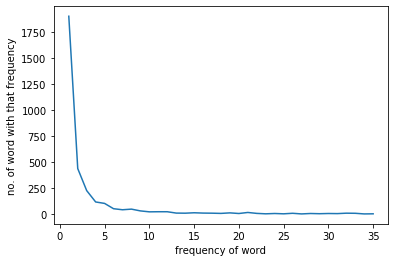

In [39]:
plt.plot(xf2,yf2)
plt.xlabel('frequency of word')
plt.ylabel('no. of word with that frequency')
plt.show()